# 🥱 LangGraph_CRAG 篇

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).

# 環境建置

## 安裝套件包

在本演練中，

我們將使用以下套件：

In [ ]:
%pip install --upgrade --quiet langchain
%pip install --upgrade --quiet langchain-openai
%pip install --upgrade --quiet langgraph
%pip install --upgrade --quiet langchain-community
%pip install --upgrade --quiet chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 533.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1

我們需要設置 環境變數 OPENAI_API_KEY ，可以直接完成，如下所示：




In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

### (可用可不用)LangSmith

你用LangChain構建的許多應用程式將包含多個步驟，並多次調用LLM調用。隨著這些應用程式變得越來越複雜，能夠檢查您的鏈或代理內部到底發生了什麼變得至關重要。最好的方法是與[LangSmith](https://smith.langchain.com)合作。

請注意，LangSmith 不是必需的，但它很有説明。如果您確實想使用 LangSmith，請在上面的鏈接中註冊后，請確保設置環境變數以開始記錄跟蹤：

In [ ]:
import os
import getpass
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %Z")

os.environ["LANGCHAIN_TRACING_V2"] = "false" ##想要使用記得改 true, 不要時改 false.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph CRAG-{current_time}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

# 開始設計



## 建立向量資料庫

畢竟是 RAG ，你懂的。在此用記憶體資料庫 `Chroma` 協助我們完成範例。實際案例中，會依照專案不同選用不同的向量資料庫以及保存方式。

In [ ]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="鼎泰豐由楊秉彝與妻子賴盆妹於1958年在台北創立，最初是販售食用油的小店。1972年轉型為餐廳，以小籠包聞名。現已成為國際知名的台灣美食品牌，在全球多個國家設有分店。",
        metadata={"source": "restaurant_history.txt"},
    ),
    Document(
        page_content="鼎泰豐的小籠包以18摺聞名，每個摺都代表著精湛的手藝。小籠包皮薄餡多，內有鮮美湯汁，是鼎泰豐最受歡迎的招牌菜品。每天現場手工製作，確保新鮮品質。",
        metadata={"source": "signature_dish.txt"},
    ),
    Document(
        page_content="鼎泰豐菜單豐富多樣，除了招牌小籠包外，還有蝦仁燒賣、雞湯餛飩、菜肉餛飩、排骨煨麵、韭黃蝦仁、蛋炒飯等經典菜色。素食選擇包括素小籠包、素蒸餃和各式蔬菜料理。",
        metadata={"source": "menu_items.txt"},
    ),
    Document(
        page_content="鼎泰豐的價格範圍適中，滿足不同消費需求。小籠包每籠（10個）約180-220元，主菜價格從250元到500元不等。套餐選擇豐富，單人套餐約500-700元，雙人套餐約1000-1500元。",
        metadata={"source": "pricing_info.txt"},
    ),
    Document(
        page_content="鼎泰豐台北101旗艦店營業時間為週一至週五11:00-21:30，週六、日及國定假日10:00-21:30。其他分店可能略有不同，建議顧客查詢官網或致電確認。旺季時可能需要排隊等候。",
        metadata={"source": "operation_hours.txt"},
    ),
    Document(
        page_content="鼎泰豐重視食材品質和衛生標準。所有食材每日新鮮配送，嚴格控管儲存溫度。廚房採用開放式設計，顧客可以直接觀看廚師製作過程，體現透明化的製作流程。",
        metadata={"source": "quality_control.txt"},
    ),
    Document(
        page_content="鼎泰豐的服務以親切周到聞名。工作人員接受嚴格培訓，能夠用多國語言服務國際顧客。餐廳內部裝潢簡約現代，保持整潔舒適的用餐環境。",
        metadata={"source": "service_ambiance.txt"},
    ),
    Document(
        page_content="鼎泰豐曾獲得米其林一星評鑑，是台灣首家進入米其林指南的餐廳。它也多次被國際媒體評為世界最佳餐廳之一，成為台灣美食外交的重要代表。",
        metadata={"source": "awards_recognition.txt"},
    ),
    Document(
        page_content="鼎泰豐除了堂食，也提供外帶服務。部分分店與外送平台合作，提供送餐到府服務。公司也有自營的線上商店，販售冷凍小籠包等產品，讓顧客在家也能享受鼎泰豐美味。",
        metadata={"source": "services_products.txt"},
    ),
    Document(
        page_content="鼎泰豐重視永續經營，積極採取環保措施。使用可回收包裝材料，推廣減塑行動。同時也參與社會公益，定期舉辦愛心餐會，回饋社會。",
        metadata={"source": "sustainability_csr.txt"},
    ),
]

db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever()

### 描繪狀態

In [ ]:
from typing import List
from typing_extensions import TypedDict

class AgentState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

### 相關問題評分器

評估與鼎泰豐相關的問題,並且使用更符合台灣語境的中文表述。

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# 定義輸出格式（介面）
class GradeQuestion(BaseModel):
    """用於檢查問題是否與鼎泰豐餐廳有關"""

    binary_score: str = Field(
        description="問題是否與餐廳有關? 如果是 -> '是' 如果不是 -> '否'"
    )

# 定義 LLM 呼叫流程
system = """你是一個評分員,負責評估檢索到的文件與用戶問題的相關性。\n
      只有當問題是關於以下主題時才回答:
      1. 鼎泰豐的歷史和創始人資訊
      2. 鼎泰豐的菜單和特色菜品
      3. 鼎泰豐的價格範圍
      4. 鼎泰豐的營業時間和地點
      5. 鼎泰豐的用餐體驗和服務

      如果問題是關於這些主題,請回答"是",否則回答"否"。
      """

grade_prompt = ChatPromptTemplate.from_messages(
      [
          ("system", system),
          ("human", "user question: {question}"),
      ]
  )

llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm = llm.with_structured_output(GradeQuestion)
retrieval_grader = grade_prompt | structured_llm

#測試
docs = retriever.get_relevant_documents("鼎泰豐有賣湯包嗎?")
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": "鼎泰豐有賣湯包嗎?", "document": doc_txt}))

binary_score='是'


### 檢索文檔評估器

評估與鼎泰豐相關的文檔是否與用戶問題相關，並且使用更符合台灣語境的中文表述。

In [ ]:
# 定義輸出格式（介面）
class GradeDocuments(BaseModel):
    """用於檢查檢索到的文檔是否相關。"""

    score: str = Field(
        description="文檔是否與問題相關，'是' 或 '否'"
    )

# 定義 LLM 呼叫流程
system = """你是一個評分員，負責評估檢索到的文檔與用戶問題的相關性。\n
        如果文檔包含與問題相關的關鍵詞或語義含義，請將其評為相關。\n
        給出二元評分 '是' 或 '否' 來表示文檔是否與問題相關。"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Retrieved document: \n\n {document} \n\n User question: {question}",
        ),
    ]
)

llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm = llm.with_structured_output(GradeDocuments)
docs_grader_llm = grade_prompt | structured_llm

# 測試 Agent 運作狀況
result = docs_grader_llm.invoke(
    {
        "document": "鼎泰豐菜單豐富多樣，包括招牌小籠包、各式點心、湯品、炒飯麵、蔬菜等。",
        "question": "鼎泰豐在哪裡？"
    }
)
print(result)

score='否'


### Question_Rewruiter
問題重寫器應該能更好地處理與鼎泰豐相關的問題，將用戶的原始問題轉化為更適合檢索的形式。例如，它可能會將 "鼎泰豐好吃嗎？" 這樣的問題重寫為 "鼎泰豐的菜品口味評價如何？" 或 "鼎泰豐最受歡迎的特色菜有哪些？"

In [ ]:
from langchain_core.output_parsers import StrOutputParser

# 定義 LLM 呼叫流程
system = """你是一個問題重寫器，負責將輸入的問題轉換成更適合檢索的優化版本。\n
        分析輸入問題，試圖理解其潛在的語義意圖和含義。\n
        特別注意與鼎泰豐餐廳相關的問題，包括但不限於：\n
        1. 鼎泰豐的歷史和創始人資訊
        2. 鼎泰豐的菜單和特色菜品
        3. 鼎泰豐的價格範圍
        4. 鼎泰豐的營業時間和地點
        5. 鼎泰豐的用餐體驗和服務
        請根據這些主題來優化問題。"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
llm = ChatOpenAI(model="gpt-4o", temperature=0)
question_rewriter = re_write_prompt | llm | StrOutputParser()

# 測試 Agent 運作狀況
result = question_rewriter.invoke({"question": "鼎泰豐有賣湯包嗎?"})
print(result)

鼎泰豐的菜單上有湯包嗎？


### 問答 Agent

處理與鼎泰豐相關的問題。它會嚴格根據提供的上下文來回答問題，避免產生虛假信息。同時，如果遇到與鼎泰豐無關的問題，系統會給出適當的提醒，確保對話始終圍繞鼎泰豐進行。

In [ ]:
# 定義 LLM 呼叫流程
template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

prompt = ChatPromptTemplate.from_template(
    template=template,
)
rag_chain = prompt | llm | StrOutputParser()

# 測試 Agent 運作狀況
generation = rag_chain.invoke({
    "question": "鼎泰豐有賣湯包嗎?",
    "context": "鼎泰豐的小籠包以皮薄餡多聞名，每個小籠包都有 18 個摺子，內餡使用精選豬肉，湯汁豐富。鼎泰豐堅持手工製作，確保每一顆小籠包都維持高品質。"
})
print(generation)

根據提供的上下文，鼎泰豐的小籠包以湯汁豐富聞名，但上下文中並未明確提到鼎泰豐是否有賣湯包。


## 網路檢索工具

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

### 定義節點函數以及 Agent

In [ ]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### 構建圖

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

### 可視化整張圖

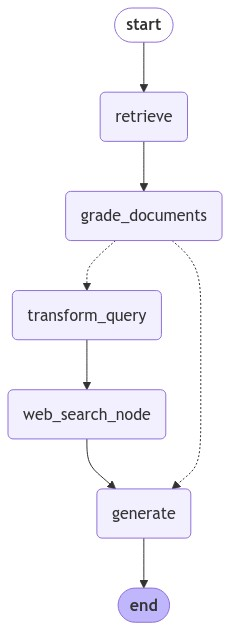

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### 與圖做互動

In [ ]:
result = app.invoke({"question": "今天天氣如何？"})
result

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---WEB SEARCH---
---GENERATE---


{'question': '今天天氣預報是什麼？',
 'generation': '根據提供的文件內容，今天天氣預報提到高空擾動會在明日為廣東沿岸帶來驟雨及雷暴，但沒有具體提到今天的天氣狀況。',
 'web_search': 'Yes',
 'documents': [Document(page_content='九天天氣預報 高空擾動會在明日為廣東沿岸帶來驟雨及雷暴。隨 著高空擾動遠離及受一股大陸氣流影響，本週中期 華南天色明朗，高溫亦會觸發驟雨。而一道廣闊低 壓槽會在本週後期為南海中北部帶來不穩定天氣。\n1週預報| 交通部中央氣象署\n香港九天天氣預報\n今日與今晚的精忠, 臺北市天氣預報、天氣狀況和都卜勒雷達，盡在 The Weather Channel 和 Weather.com Advertisement. Advertisement. Advertisement. 跳到 ... 今天. 每 ...\n香港天文台- 天氣報告')]}

In [ ]:
result = app.invoke({"question": "鼎泰豐有賣湯包嗎？"})
result

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---WEB SEARCH---
---GENERATE---


{'question': '鼎泰豐的菜單上有湯包嗎？',
 'generation': '是的，鼎泰豐的菜單上有湯包，但這款「小籠湯包」只在週末早上販售，且全台僅有5家門市供應。',
 'web_search': 'Yes',
 'documents': [Document(page_content='"小籠包"是鼎泰豐的經典美食之一，不僅揚名海內外，連鼎泰豐的吉祥物也是以"小籠包"為雛形設計，足以印證其代表性。但你可知道鼎泰豐除了"小籠包"外，還有一款只在週末早上販售的"小籠湯包"，全台僅有5家門市供應，讓我對這款限時限店的產品十分好奇，特地找了個時間來嘗試。\n鼎泰豐小籠包的招牌特色就是外皮的黃金十八摺!! 仔細看每顆手工現做的小籠包上面都真的有18個摺子喔xd. 口味上也蠻不錯，算是皮薄肉鮮蠻多汁!所以吃得時候凱西 會建議搭配小湯匙比較不會燙到xd. 再來鼎泰豐菜單推薦的另一道菜是排骨蛋炒飯!炸排骨看 ...\n以最經典招牌「黃金18摺小籠包」揚名海內外的鼎泰豐，是許多人到百貨公司不知道要吃什麼的時候，就會進去點一籠小籠包、一份排骨炒飯解饞的人氣餐廳。然而除了眾所皆知的小籠包之外，其實鼎泰豐還有超級限量「小籠湯包」僅在限定門市、時段販售，讓太晚起床的吃貨、饕客至今都還沒...\n小籠湯包(每周六、日門市賞味限定) - 鼎泰豐\n鼎泰豐5大隱藏吃法曝光!這款小籠包可以點單顆、牛肉麵能 ...')]}

In [ ]:
from pprint import pprint

# Run
inputs = {"question": "鼎泰豐有賣湯包嗎？"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
'有的，鼎泰豐的菜單上有「小籠湯包」，但這款湯包只在週末早上販售，全台僅有5家門市供應。'
